 #  Kris Profit

---

# Adult Data Set
### Also known as "Census Income" dataset

### Predict whether income exceeds 50K per year based on census data

---

# Import Packages

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn import preprocessing, svm, tree
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import Lasso, Ridge, ElasticNet

import seaborn as sns

import time
from operator import itemgetter
import os

import warnings
warnings.filterwarnings("ignore")

---

# Import Dataset

In [120]:
Adult_Original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',header=None,
                        na_values='?')

Adult_Original.shape


(32561, 15)

In [121]:
print(Adult_Original.columns)
Adult_Original.head()

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Need to insert column names

In [122]:
Adult_Original.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
                     'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country',
                     'income']
Adult_Original.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There is a 'test set' given from the UCI Machine Learning Repository. I am going to append that to the dataframe before moving forward. I am choosing to append now and split into train/test later to get a more thorough look at the data. Need to skip first row when importing, since there is an irregular row that makes the DF read as one column.

In [123]:
Adult_test_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',header = None,
                             na_values = '?',skiprows = 1)
print(Adult_test_data.shape)
Adult_test_data.head(3)

(16281, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.


In [124]:
Adult_test_data.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
                     'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country',
                     'income']
Adult_test_data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.


Looks good, except that in column 14, there is a period at the end of each value. We'll need to remove that so there aren't four different target values. 

In [125]:
Adult_test_data['income'] = Adult_test_data['income'].str.replace(".","")

Adult_test_data['income'].head(3)

0     <=50K
1     <=50K
2      >50K
Name: income, dtype: object

Period has been removed. Now let's append to the other dataframe.

In [128]:
Adult_Original = Adult_Original.append(Adult_test_data,ignore_index = True)
Adult_Original.shape

(48842, 15)

We now have the full number of instances to continue with data prep and EDA.

### Move target feature to column 0

In [129]:
# designate target variable name
targetName = 'income'
targetSeries = Adult_Original[targetName]
#remove target from current location and insert in collum 0
del Adult_Original[targetName]
Adult_Original.insert(0, targetName, targetSeries)
#reprint dataframe and see target is in position 0
Adult_Original.head(3)

,income,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,<=50K,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


### Check for missing values

When importing the data, we set "?" values to be read as NA. Let's see how many there are. We may need to revisit this if there are other missing value entries such as "-" or " ".

In [130]:
np.sum(Adult_Original.isnull())

income            0
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

#### There are no missing values here (as far as we can tell)

# Exploratory Data Analysis

### Get data info

What are the basic characteristics of the data? Are the data types appropriate for each attribute? Is there any need for standardiation?

In [131]:
print(Adult_Original.info())
print(Adult_Original.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
income            48842 non-null object
age               48842 non-null int64
workclass         48842 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
st

All attributes seem to be in appropriate data types. Capital-gain has much higher values than the other numeric types. We will standardize the attributes as we move forward so that they do not dominate the other numeric variables. 

### What is the distribution of the target?

 <=50K    37155
 >50K     11687
Name: income, dtype: int64


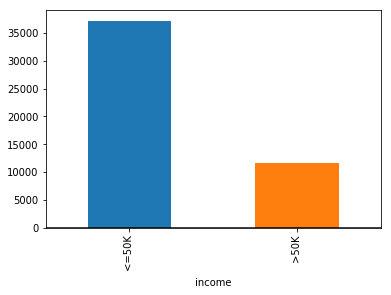

In [132]:
groupby = Adult_Original.groupby(targetName)
targetEDA=groupby[targetName].aggregate(len)
plt.figure()
targetEDA.plot(kind='bar', grid=False)
plt.axhline(0, color='k')

print(Adult_Original.income.value_counts())

The distribution of the target attribute is skewed toward <=50K. This may require oversampling techniques or parameter tuning to obtain an adequate number of instances from the positive class.

## What is the distribution of all attributes?

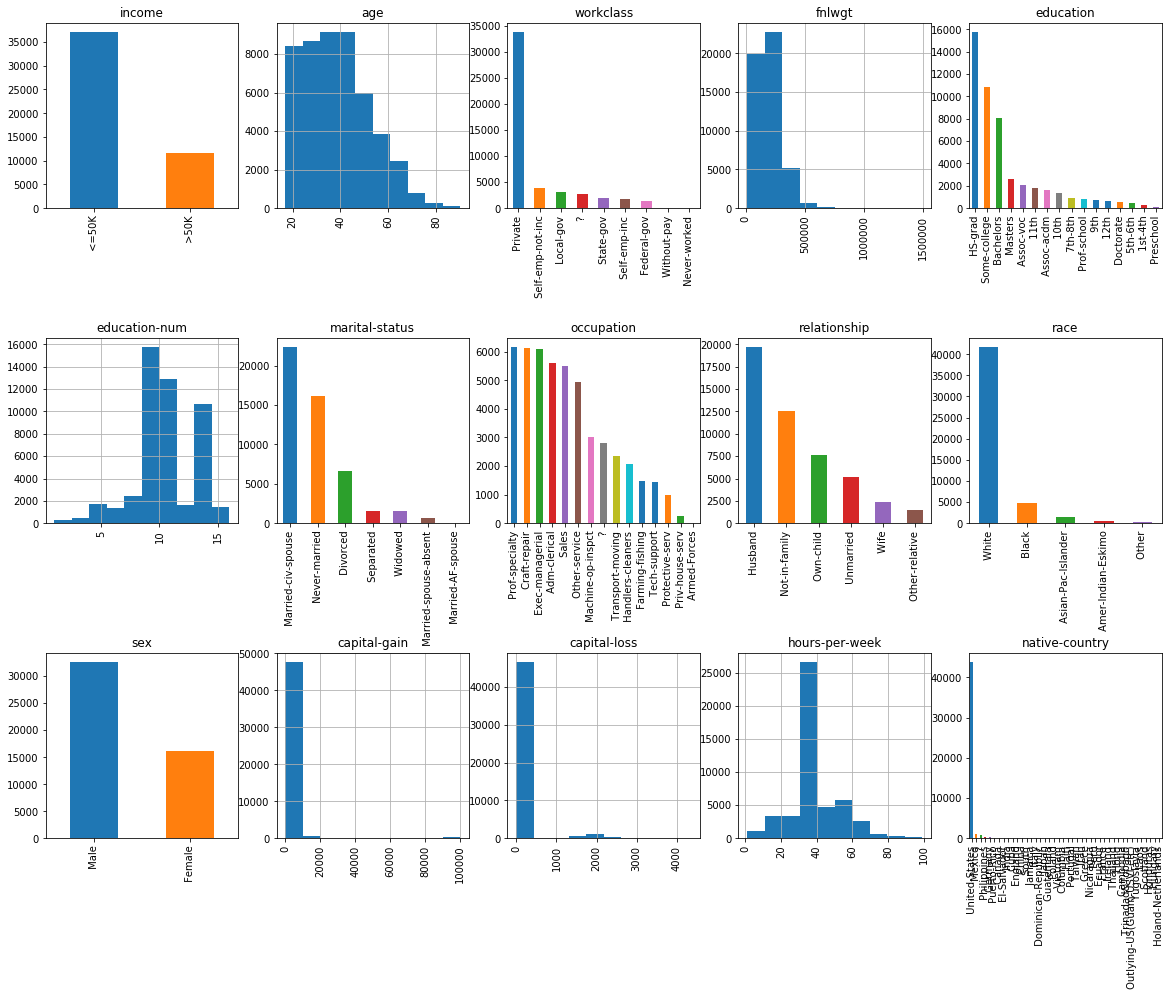

In [133]:
fig2 = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(Adult_Original.shape[1]) / cols)
for i, column in enumerate(Adult_Original.columns):
    ax = fig2.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if Adult_Original.dtypes[column] == np.object:
        Adult_Original[column].value_counts().plot(kind="bar", axes=ax)
    else:
        Adult_Original[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Looking at these graphs, it should be noted that there are over twice the number of instances with sex = Male, which also leads to very skewed distributions in the marital-status and relationship attributes. Race = white and native-country = United States also hold large majorities in their respective dimensions. These should be remembered as we move forward with the analysis. 

There do not seem to be any errors in the data, such as typos that return duplicates of the same value. There are categorical values of "?" in the workclass and occupation attributes. These are acceptable since they are not numeric attributes. The "?" category will simply be treated as "unknown".

I noticed the attribute, "fnlwgt", and after discovering that it simply refers to the number of people that the census takers believed the instance to represent, I decided to remove it from the dataset.

## Create dummies and Standardize

We need to convert the target attribute values to numeric so that scikit learn algorithms can process it. There are several categorical attributes that need to be turned into dummy variables (0,1) and there are continuous variables that should be standardized, those being 'capital-gain' and 'capital loss'

In [134]:
# Create copy of df, drop 'fnlwgt'
Adult = Adult_Original
Adult = Adult.drop(columns=['fnlwgt'])

# Target attribute transform
from sklearn import preprocessing
le_dep = preprocessing.LabelEncoder()
#to convert into numbers
Adult['income'] = le_dep.fit_transform(Adult['income'])

# Dummies
for col in Adult.columns[1:]:
	attName = col
	dType = Adult[col].dtype
	missing = pd.isnull(Adult[col]).any()
	uniqueCount = len(Adult[attName].value_counts(normalize=False))
	# discretize (create dummies)
	if dType == object:
		Adult = pd.concat([Adult, pd.get_dummies(Adult[col], prefix=col)], axis=1)
		del Adult[attName]
        
# Standardize
Adult['capital-gain'] = preprocessing.scale(Adult['capital-gain'])
Adult['capital-loss'] = preprocessing.scale(Adult['capital-loss'])

/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Let's take a look at the dataframe after making these adjustments.

In [135]:
print(Adult.shape)
Adult.head(5)


(48842, 108)


,income,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,39,13,0.146932,-0.217127,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,50,13,-0.144804,-0.217127,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,38,9,-0.144804,-0.217127,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,53,7,-0.144804,-0.217127,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,28,13,-0.144804,-0.217127,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Partition Data

In [136]:
features_train, features_test, target_train, target_test = train_test_split(
    Adult.iloc[:,1:].values, Adult.iloc[:,0].values, test_size=0.4, random_state=0)

Let's see how the split worked:

In [137]:
print(features_test.shape)
print(features_train.shape)
print(target_test.shape)
print(target_train.shape)

(19537, 107)
(29305, 107)
(19537,)
(29305,)


# Baseline Decision Tree

In [138]:
# Import tree from scikit learn
from sklearn import tree
# Call up model and assign it a name. 
BasicTree = tree.DecisionTreeClassifier()
# Now see the parameters
print(BasicTree)
# Alter parameters
BasicTree = tree.DecisionTreeClassifier()
# Fit the model with partitioned set
BasicTree = BasicTree.fit(features_train, target_train)
# Now predict using the features test
BasicTree_predict = BasicTree.predict(features_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### What is the tree's accuracy?

Decision Tree Accuracy Score:  0.821927624507345
             precision    recall  f1-score   support

          0       0.88      0.89      0.88     14939
          1       0.63      0.60      0.61      4598

avg / total       0.82      0.82      0.82     19537



Text(0.5,1,'Confusion Matrix')

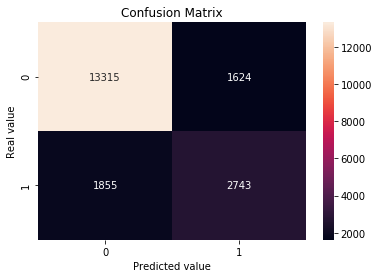

In [139]:
print('Decision Tree Accuracy Score: ', accuracy_score(target_test, BasicTree_predict))
print(classification_report(target_test, BasicTree_predict))

Tree_cm = confusion_matrix(target_test, BasicTree_predict)
sns.heatmap(Tree_cm, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.title("Confusion Matrix")

### Cross-Validation to check consistency of accuracy scores

In [88]:
# Will use K = 10
BasicTree_CV_scores = cross_val_score(BasicTree, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', BasicTree_CV_scores)
print('CV mean score: ', BasicTree_CV_scores.mean())  

CV Score for each K [0.82497441 0.81576254 0.81525077 0.80962129 0.81013306 0.81320368
 0.81371546 0.79774706 0.80491551 0.81557377]
CV mean score:  0.8120897548675223


After cross-validation, the accuracy average was shown to be .812. There is good consistency among the accuracy scores for each K in the cross-validation, indicating the model did not overfit the train data. Although the accurcay of this model is quite good, the true positive rate was only .60, meaning that only 60% of instances with >50K income were correctly identified. While this metric value is not the worst in the world, it will hopefully improve as we move forward. The positive class not only had a less than desirebale recall, but the precision was .63. The F1 scores for the negative and positive calsses were .88 and .61, respectively. It is not surprising that the negative class had a much higher precision and recall, being that negative class instances far outweigh the positive class in this dataset.


##### After giving thought to the metrics that should be focused on for this analysis, I have decided to focus primarily on the accuracy and  F1 scores, although I plan on taking a more granular approach and paying attention to recall and precision as well. Though F1 scores can give quick insight in evaluating a model, if two models have the same F1 scores, there is a need to look at recall and precision to further evaluate which one would be better.

This decision tree will act as a baseline as we construct and deploy different black box models and adjust model parameters.

# KNN

Will construct another baseline model for comparison with ensemble models. Will use K = 3 and K = 5.

##### K = 3

In [89]:
# import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
# Call the model
knn3 = KNeighborsClassifier(n_neighbors = 3)
# Fit the model
knn3 = knn3.fit(features_train, target_train)
# Now predict using features test set
knn3_predict = knn3.predict(features_test)

##### K = 5

In [90]:
# Call the model
knn5 = KNeighborsClassifier(n_neighbors = 5)
# Fit the model
knn5 = knn5.fit(features_train, target_train)
# Now predict using features test set
knn5_predict = knn5.predict(features_test)

### What are the accuracies?

##### K = 3

In [91]:
print("KNN accuracy score: ",accuracy_score(target_test,knn3_predict))
print(classification_report(target_test, knn3_predict))
print(confusion_matrix(target_test, knn3_predict))

KNN accuracy score:  0.8029942418426104
             precision    recall  f1-score   support

          0       0.86      0.88      0.87      9873
          1       0.60      0.56      0.58      3152

avg / total       0.80      0.80      0.80     13025

[[8696 1177]
 [1389 1763]]


##### K = 5

In [92]:
print("KNN accuracy score: ",accuracy_score(target_test,knn5_predict))
print(classification_report(target_test, knn5_predict))
print(confusion_matrix(target_test, knn5_predict))

KNN accuracy score:  0.8145873320537428
             precision    recall  f1-score   support

          0       0.87      0.89      0.88      9873
          1       0.63      0.57      0.60      3152

avg / total       0.81      0.81      0.81     13025

[[8800 1073]
 [1342 1810]]


### Cross-Validation

##### K = 3

In [93]:
KNN3_CV_scores = cross_val_score(knn3, features_train, target_train, cv=10)
print('CV Score for each K', KNN3_CV_scores)
print('CV mean score: ', KNN3_CV_scores.mean()) 

CV Score for each K [0.80296827 0.80910952 0.80962129 0.79324463 0.79785056 0.8024565
 0.79580348 0.79825909 0.80081925 0.81608607]
CV mean score:  0.8026218654284627


##### K = 5

In [95]:
KNN5_CV_scores = cross_val_score(knn5, features_train, target_train, cv=10)
print('CV Score for each K', KNN5_CV_scores)
print('CV mean score: ', KNN5_CV_scores.mean()) 

CV Score for each K [0.80757421 0.81269191 0.81883316 0.80808598 0.80603889 0.81269191
 0.80962129 0.80389145 0.81157194 0.81557377]
CV mean score:  0.8106574519411792


### KNN Summary

The KNN algorithm with k = 5 performed better than k = 3. Overall, KNN performed slightly less well than the baseline decision tree. After cross-validating, the mean accuracy score for k = 5 was .81, compared to the decision tree's .812. The recall for k = 5 was .57 and recall for k = 3 was .56. These recall values render the KNN significantly less useful in making predicitons compared to the decision tree. We will now move on to our ensembles.

# Random Forest

### Random Forest 1 

In [140]:
# train random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
print(rf)

RF_1 = RandomForestClassifier(n_estimators= 500, n_jobs=-1,oob_score=True)
RF_1.fit(features_train, target_train)
# test random forest model
RF_1_predicted = RF_1.predict(features_test)
print(accuracy_score(target_test, RF_1_predicted))
target_names = ["<=50K", ">50K"]
print(classification_report(target_test, RF_1_predicted, target_names=target_names))
print(confusion_matrix(target_test, RF_1_predicted))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8495163024005733
             precision    recall  f1-score   support

      <=50K       0.89      0.92      0.90     14939
       >50K       0.71      0.62      0.66      4598

avg / total       0.84      0.85      0.85     19537

[[13750  1189]
 [ 1751  2847]]


The random forest model performed better than the basic decision tree. It had nearly .03 higher overall accuracy, with .02 higher recall and .08 higher precision for the positive class. The negative class metrics were improved by similar amounts. Let's perform a cross-validation to see the model's consistency. 

### Cross-Validation

In [141]:
RF_1_scores = cross_val_score(RF_1, features_train, target_train, cv=10, n_jobs=-1)
print("Cross Validation Score for each K",RF_1_scores)
RF_1_scores.mean()

Cross Validation Score for each K [0.85056295 0.84476288 0.85022177 0.8338451  0.85226885 0.85465711
 0.84368601 0.84812287 0.83617747 0.84465688]


0.845896189017642

Performing cross-validation shows that this model is very consistent, with a mean accuracy of .846 and a spread of only +/- .01.

#### Confusion matrix

[[13750  1189]
 [ 1751  2847]]


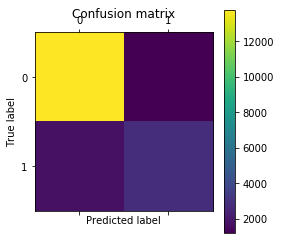

In [142]:
RF_1_cm = confusion_matrix(target_test, RF_1_predicted)
plt.matshow(RF_1_cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(RF_1_cm)

### Hyperparameter Tuning

In [143]:
param_grid = {"max_features": [3, 4, 5, 7, 9, 14]}
start_time = time.clock()

# run grid search
grid_search = GridSearchCV(RF_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

Time to run 49.367766000000074 seconds
{'mean_fit_time': array([20.72156572, 22.14280836, 23.72793555, 25.34362737, 29.02665567,
       23.31775864]), 'std_fit_time': array([0.28012395, 0.01226433, 0.80760939, 0.66148805, 0.19307368,
       6.05444874]), 'mean_score_time': array([1.22487871, 1.1639696 , 1.04847638, 1.00968591, 1.03949173,
       0.76130875]), 'std_score_time': array([0.13845373, 0.21196118, 0.17316181, 0.13353504, 0.14425577,
       0.09535259]), 'param_max_features': masked_array(data=[3, 4, 5, 7, 9, 14],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 3}, {'max_features': 4}, {'max_features': 5}, {'max_features': 7}, {'max_features': 9}, {'max_features': 14}], 'split0_test_score': array([0.83560242, 0.83744498, 0.83908281, 0.8414372 , 0.84389395,
       0.84512233]), 'split1_test_score': array([0.83896396, 0.83916871, 0.84172809, 0.84336609, 0.84572072,
       0.84479934]), 's

The best mean test score was at max_features = 14 (.8445). This number is the total number of features used in the model, so considering only a subset of the features at each split will not be necessary. The RF's original accuray score was .849 and the CV mean score was .846. 

### What is the importance of each predictor?

In [144]:
print("Features sorted by their score:")
print("Higher the more important")
print(sorted(zip(map(lambda x: round(x, 4), RF_1.feature_importances_),Adult.columns[1:14]), 
             reverse=True))

Features sorted by their score:
Higher the more important
[(0.2293, 'age'), (0.1137, 'hours-per-week'), (0.1058, 'capital-gain'), (0.0644, 'education-num'), (0.0331, 'capital-loss'), (0.0116, 'workclass_ Private'), (0.0093, 'workclass_ Self-emp-not-inc'), (0.0067, 'workclass_ Local-gov'), (0.0065, 'workclass_ Self-emp-inc'), (0.0057, 'workclass_ Federal-gov'), (0.0053, 'workclass_ State-gov'), (0.0019, 'workclass_ ?'), (0.0, 'workclass_ Never-worked')]


The importance of each feature in the Random Forest model seem intuitive. Age explains 22.93% of the variance, hours worked per week explains 11.37% of the variance, capital gain explains 10.58% of the variance, and education-num explains 6.44% of the variance. Age and hours per week are intuitive indicators of whether or not someone would make over 50K. Capital gain, which I assume is the amount of non-income investment growth someone has earned, is another intuitive indicator of higher income, as is education level.

### Random Forest 2 - using 'balanced' class weights

Let's play around with tuning - Since the distribution of the target variable is skewed, let's see how adding class weights affects the model's accuracy.

In [145]:
rf = RandomForestClassifier()
print(rf)
# train random forest model
from sklearn.ensemble import RandomForestClassifier
RF_2 = RandomForestClassifier(n_estimators= 500,class_weight = 'balanced', n_jobs=-1,oob_score=True)
RF_2.fit(features_train, target_train)
# test random forest model
RF_2_predicted = RF_2.predict(features_test)
print(accuracy_score(target_test, RF_2_predicted))
target_names = ["<=50K", ">50K"]
print(classification_report(target_test, RF_2_predicted, target_names=target_names))
print(confusion_matrix(target_test, RF_2_predicted))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8463428366688847
             precision    recall  f1-score   support

      <=50K       0.89      0.91      0.90     14939
       >50K       0.68      0.65      0.66      4598

avg / total       0.84      0.85      0.84     19537

[[13565  1374]
 [ 1628  2970]]


Using the 'balanced' class weights did virtually nothing to improve the Random Forest. The accuracy, precision, and recall metrics are similar. Adding the balanced class weight parameter did not increase overall accuracy and increased the true positive rate by .03 at the expense of .03 in precision. The F1 score was unchanged. The negative class metrics were virtually unchanged.

#### Cross-Validation

In [146]:
RF_2_scores = cross_val_score(RF_2, features_train, target_train, cv=10, n_jobs=-1)
print("Cross Validation Score for each K",RF_2_scores)
RF_2_scores.mean()

Cross Validation Score for each K [0.84817468 0.83964517 0.85158649 0.83145684 0.8461276  0.84919823
 0.83754266 0.8447099  0.82696246 0.84397405]


0.841937808363092

The mean CV score for the RF model with balance class weights was slightly lower than the original RF model. There is good consistency here, and it seems like it really wouldn't matter which model was used, though I would choose the first because of the slightly better metrics.

### Random Forest 3 - balanced class weights and min_impurity_decrease

In addition to having the balanced class weight parameter in place, let's also play around with the min_impurity_decrease parameter. This parameter ensures that a split in each tree must reduce impurity among the instances in each node by a certain amount, or else the split will not occur. This is expected to result in a model that "casts a wider net". We may see higher recall for the positive class of the target variable, but perhaps at a cost in precision and overall accuracy.

In [147]:
rf = RandomForestClassifier()
print(rf)
# train random forest model
from sklearn.ensemble import RandomForestClassifier
RF_3 = RandomForestClassifier(n_estimators= 500,class_weight = 'balanced', min_impurity_decrease = .01, n_jobs=-1,oob_score=True)
RF_3.fit(features_train, target_train)
# test random forest model
RF_3_predicted = RF_3.predict(features_test)
print(accuracy_score(target_test, RF_3_predicted))
target_names = ["<=50K", ">50K"]
print(classification_report(target_test, RF_3_predicted, target_names=target_names))
print(confusion_matrix(target_test, RF_3_predicted))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.731637405947689
             precision    recall  f1-score   support

      <=50K       0.94      0.70      0.80     14939
       >50K       0.46      0.84      0.60      4598

avg / total       0.82      0.73      0.75     19537

[[10415  4524]
 [  719  3879]]


As expected, by adding this parameter, the recall for the positive class increased significantly, and the precision and accuracy decreased, as well as the negative class recall. I did not expect that adding the min_impurity_decrease parameter of only .01 would have such a large effect. Let's try a grid search to see if there are any better values to put in the parameter.

#### min_impurity_decrease Grid Search

In [148]:
param_grid = {"min_impurity_decrease": [.1,.05,.01,.005,.001]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(RF_3, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

Time to run 18.978584999999953 seconds
{'mean_fit_time': array([ 7.35563135,  9.98679336, 11.65175939, 12.37578034, 11.99845354]), 'std_fit_time': array([0.34869247, 1.00392318, 0.28900527, 0.45785682, 0.12711527]), 'mean_score_time': array([0.48684827, 0.49667128, 0.62221313, 0.62567329, 0.52313813]), 'std_score_time': array([0.09650956, 0.04111563, 0.08707915, 0.08961868, 0.14942486]), 'param_min_impurity_decrease': masked_array(data=[0.1, 0.05, 0.01, 0.005, 0.001],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_impurity_decrease': 0.1}, {'min_impurity_decrease': 0.05}, {'min_impurity_decrease': 0.01}, {'min_impurity_decrease': 0.005}, {'min_impurity_decrease': 0.001}], 'split0_test_score': array([0.70887501, 0.71716655, 0.72934794, 0.7311905 , 0.77745931]), 'split1_test_score': array([0.70833333, 0.71457821, 0.72563473, 0.73628174, 0.77272727]), 'split2_test_score': array([0.71191646, 0.71918509, 0.73341523, 

The grid search indicates that the highest accurcacy will be with a min_impurity_decrease value of .001. This is a very small value, but lets see how it does.

### Random Forest 4

In [149]:
rf = RandomForestClassifier()
print(rf)
# train random forest model
from sklearn.ensemble import RandomForestClassifier
RF_4 = RandomForestClassifier(n_estimators= 500,class_weight = 'balanced', min_impurity_decrease = .001, n_jobs=-1,oob_score=True)
RF_4.fit(features_train, target_train)
# test random forest model
RF_4_predicted = RF_4.predict(features_test)
print(accuracy_score(target_test, RF_4_predicted))
target_names = ["<=50K", ">50K"]
print(classification_report(target_test, RF_4_predicted, target_names=target_names))
print(confusion_matrix(target_test, RF_4_predicted))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.7800583508215182
             precision    recall  f1-score   support

      <=50K       0.94      0.76      0.84     14939
       >50K       0.52      0.85      0.65      4598

avg / total       0.84      0.78      0.79     19537

[[11316  3623]
 [  674  3924]]


This model did better all-around than the previous one. The recall for both classes was higher, and the accuracy and precision metrics improved. However, the precision is still very low (.52). Because of this, I would prefer to stick with the original Random Forest for this particular dataset. 

#### Cross-Validation

In [155]:
RF_4_scores = cross_val_score(RF_4, features_train, target_train, cv=10, n_jobs=-1)
print("Cross Validation Score for each K",RF_4_scores)
RF_4_scores.mean()

Cross Validation Score for each K [0.77311498 0.78266803 0.76731491 0.76731491 0.77311498 0.76322074
 0.77269625 0.78020478 0.76279863 0.77705702]


0.7719505224732444

The CV scores are consistent, though lower than Random Forests 1 and 2. 

Random Forest 1 will be chosen as the best RF model.

## Illustrate Random Forest 1's precision and recall with a ROC curve

ROC AUC: 0.892


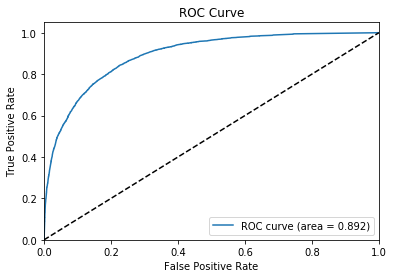

In [150]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, RF_1.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.3f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The ROC curve shows that Random Forest 1 is a very solid model. The steepness of the curve shows that the model can identify over 80% of the positives without sacrificing too much precision and overall accuracy. 

# Extra Trees

### Extra Trees Model 1 (No tuning)

In [158]:
from sklearn.ensemble import ExtraTreesClassifier
XTree_1 = ExtraTreesClassifier()
XTree_1.fit(features_train, target_train)
XTree_1_predicted=XTree_1.predict(features_test)
expected = target_test
print("Extra Trees", accuracy_score(expected,XTree_1_predicted))
print(classification_report(expected, XTree_1_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, XTree_1_predicted))

Extra Trees 0.8250499053078774
             precision    recall  f1-score   support

         No       0.87      0.91      0.89     14939
        Yes       0.65      0.54      0.59      4598

avg / total       0.82      0.83      0.82     19537

[[13616  1323]
 [ 2095  2503]]


The extra trees model, with no tuning, did not preform as well as the Random Forest model. While its overall accuracy was good, the positive class metrics were a bit lower than the RF. The recall was .54 with .65 precision, resulting in an F1 score of .59. 

#### Cross-validate

In [160]:
# Will use K = 10
XTree_1_CV_scores = cross_val_score(XTree_1, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', XTree_1_CV_scores)
print('CV mean score: ', XTree_1_CV_scores.mean())  

CV Score for each K [0.82668031 0.82088025 0.82702149 0.81610372 0.82770386 0.82497441
 0.82150171 0.82491468 0.82013652 0.8350973 ]
CV mean score:  0.8245014243434557


The 10 CV scores are all within +/- .01 of the mean. This is good consistency. Let's add some parameters to see if the model's metrics can be improved. First, the model needs to be printed to display the argument options.

In [159]:
print(XTree_1)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


### Extra Trees 2

Going to add 'balanced' class weights

In [161]:
XTree_2 = ExtraTreesClassifier(class_weight='balanced')
XTree_2.fit(features_train, target_train)
XTree_2_predicted=XTree_2.predict(features_test)
expected = target_test
print("Extra Trees", accuracy_score(expected,XTree_2_predicted))
print(classification_report(expected, XTree_2_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, XTree_2_predicted))

Extra Trees 0.819829042329938
             precision    recall  f1-score   support

         No       0.88      0.89      0.88     14939
        Yes       0.62      0.60      0.61      4598

avg / total       0.82      0.82      0.82     19537

[[13279  1660]
 [ 1860  2738]]


Positive class recall increased by .06, while positive class precision decreased by .03. The average F1 score was unchanged. The overall accuracy for this model was .006 lower than the first. Since this difference is so small, it shouldn't matter which model is used. I usually lean toward the model that has higher recall- this one does for the positive class, although the negative class recall was .02 lower. Let's see what the cross-validation scores tell us about the model's accuracy and consistency.

In [162]:
# Will use K = 10
XTree_2_CV_scores = cross_val_score(XTree_2, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', XTree_2_CV_scores)
print('CV mean score: ', XTree_2_CV_scores.mean())  

CV Score for each K [0.8164449  0.81235073 0.8198567  0.80723303 0.81951552 0.81678608
 0.80784983 0.81774744 0.80375427 0.8197337 ]
CV mean score:  0.8141272200249354


The CV scores are all within .01 of the mean, however none reach .82 accuracy. The first model's mean CV score was .824, a full percentage point higher than the second model.

### Extra Trees 3

Going to add max depth and min-impurity split parameters. This could have a large effect on recall and precision.

In [170]:
XTree_3 = ExtraTreesClassifier(max_depth=5,min_impurity_decrease=.001)
XTree_3.fit(features_train, target_train)
XTree_3_predicted=XTree_3.predict(features_test)
expected = target_test
print("Extra Trees", accuracy_score(expected,XTree_3_predicted))
print(classification_report(expected, XTree_3_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, XTree_3_predicted))

Extra Trees 0.8158878026309054
             precision    recall  f1-score   support

         No       0.83      0.96      0.89     14939
        Yes       0.72      0.36      0.48      4598

avg / total       0.80      0.82      0.79     19537

[[14297   642]
 [ 2955  1643]]


The recall for the positive class went down dramatically to .36 with a relatively higher precision of 72. The negative class has a recall of .96 with precision of .81. Let's do a grid search to find the best depth of the tree and the pest min_impurity_decrease value.

#### min_impurity_decrese Grid Search

In [171]:
param_grid = {"min_impurity_decrease": [.05,.01,.005,.001]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(XTree_3, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

Time to run 0.9591410000000451 seconds
{'mean_fit_time': array([0.16955725, 0.26699464, 0.3138895 , 0.29032834]), 'std_fit_time': array([0.03200745, 0.02035345, 0.00493228, 0.03442157]), 'mean_score_time': array([0.01514546, 0.01853657, 0.02193554, 0.01237559]), 'std_score_time': array([0.0043655 , 0.00221969, 0.00429036, 0.00290583]), 'param_min_impurity_decrease': masked_array(data=[0.05, 0.01, 0.005, 0.001],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_impurity_decrease': 0.05}, {'min_impurity_decrease': 0.01}, {'min_impurity_decrease': 0.005}, {'min_impurity_decrease': 0.001}], 'split0_test_score': array([0.7581124 , 0.7581124 , 0.77326236, 0.81533422]), 'split1_test_score': array([0.75808763, 0.75808763, 0.78214578, 0.81470106]), 'split2_test_score': array([0.75808763, 0.75808763, 0.79381654, 0.80702293]), 'mean_test_score': array([0.75809589, 0.75809589, 0.78307456, 0.81235284]), 'std_test_score': array([1.1673

The best min_impurity_decease value was .001, which is what we had entered. Let's do the same for max_depth.

#### max_depth Grid Search

In [172]:
param_grid = {"max_depth": [3,4,5,6,7]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(XTree_3, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

Time to run 1.1127500000000055 seconds
{'mean_fit_time': array([0.26590236, 0.36660385, 0.40497724, 0.41052731, 0.2651639 ]), 'std_fit_time': array([0.05228144, 0.01318346, 0.01869197, 0.01926981, 0.07293738]), 'mean_score_time': array([0.02169466, 0.02517001, 0.02353207, 0.02081736, 0.01231265]), 'std_score_time': array([0.00315709, 0.00564354, 0.00362491, 0.00294365, 0.00314444]), 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 3}, {'max_depth': 4}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}], 'split0_test_score': array([0.77684512, 0.77356945, 0.81533422, 0.81257038, 0.80601904]), 'split1_test_score': array([0.7787674 , 0.80364455, 0.81470106, 0.82248157, 0.8244267 ]), 'split2_test_score': array([0.77579853, 0.79412367, 0.80036855, 0.81265356, 0.81674857]), 'mean_test_score': array([0.77713701, 0.79044532, 0.81013479, 0.81590172, 0.8157311

According to the grid search, the best max_depth value is 6. Let's make the adjustment and see what happens.

### Extra Trees 4

In [173]:
XTree_4 = ExtraTreesClassifier(max_depth=6,min_impurity_decrease=.001)
XTree_4.fit(features_train, target_train)
XTree_4_predicted=XTree_4.predict(features_test)
expected = target_test
print("Extra Trees", accuracy_score(expected,XTree_4_predicted))
print(classification_report(expected, XTree_4_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, XTree_4_predicted))

Extra Trees 0.8148641040077801
             precision    recall  f1-score   support

         No       0.82      0.98      0.89     14939
        Yes       0.81      0.28      0.41      4598

avg / total       0.81      0.81      0.78     19537

[[14644   295]
 [ 3322  1276]]


These parameters did not improve the model. Let's adjust it and remove the min_impurity_decrease.

In [174]:
XTree_4 = ExtraTreesClassifier(max_depth=6)
XTree_4.fit(features_train, target_train)
XTree_4_predicted=XTree_4.predict(features_test)
expected = target_test
print("Extra Trees", accuracy_score(expected,XTree_4_predicted))
print(classification_report(expected, XTree_4_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, XTree_4_predicted))

Extra Trees 0.8236679121666581
             precision    recall  f1-score   support

         No       0.84      0.96      0.89     14939
        Yes       0.74      0.39      0.51      4598

avg / total       0.81      0.82      0.80     19537

[[14293   646]
 [ 2799  1799]]


Removing the min_impurity_decrease improved the model significantly, but it is still performing much worse than the Extra Trees 1 and 2 models. We should still cross validate this one to see if it is consisitent.

#### Cross-Validate

In [175]:
# Will use K = 10
XTree_4_CV_scores = cross_val_score(XTree_4, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', XTree_4_CV_scores)
print('CV mean score: ', XTree_4_CV_scores.mean())  

CV Score for each K [0.82360969 0.814739   0.82326851 0.82770386 0.81235073 0.81064483
 0.81535836 0.81331058 0.8116041  0.81700239]
CV mean score:  0.8169592042926418


The model is consistent, and the overall accuracy is not bad. However, this is due to high metrics for the negative class. The positive class recall is unacceptably low.

# SVM Linear

### Baseline SVM Linear

In [176]:
# Without any parameters

from sklearn.svm import LinearSVC
SVM_1 = LinearSVC()
SVM_1.fit(features_train, target_train)
SVM_1_predicted = SVM_1.predict(features_test)
expected = target_test
# summarize the fit of the modeld
print(classification_report(expected, SVM_1_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, SVM_1_predicted))
print(accuracy_score(expected,SVM_1_predicted))

             precision    recall  f1-score   support

         No       0.82      0.99      0.89     14939
        Yes       0.89      0.27      0.41      4598

avg / total       0.83      0.82      0.78     19537

[[14793   146]
 [ 3356  1242]]
0.8207503710907509


This baseline SVM model had an overall accuracy of .841. The negative class metrics were all very high: .82 precision, .99 recall, resulting in a .89 F1 score. The positive class had good precision (.89), but the recall was only .27, resulting in a F1 score of .41. 

#### Cross-Validation

In [177]:
# Will use K = 10
SVM_1_CV_scores = cross_val_score(SVM_1, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', SVM_1_CV_scores)
print('CV mean score: ', SVM_1_CV_scores.mean())  

CV Score for each K [0.82122143 0.70999659 0.52644149 0.54247697 0.85124531 0.64346639
 0.80682594 0.83651877 0.8447099  0.82109935]
CV mean score:  0.7404002133507381


The mean CV score was .74. The scores have a larger spread than is desirebale, with most ranging between .80 and .85, with some low scores (.524 ; .526 ; .643). This, paired with the lower positive class metrics makes the Random Forest a more desireable model thus far, but we will see if adjusting parameters will improve this. 

Let's print out the model to see what parameters can be tuned.

In [178]:
print(SVM_1)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


### SVM Linear 2

In this model, we are going to add class weights to balance the target variable's distribution. 

In [179]:
from sklearn.svm import LinearSVC
SVM_2 = LinearSVC(class_weight='balanced')
SVM_2.fit(features_train, target_train)
SVM_2_predicted = SVM_2.predict(features_test)
expected = target_test
# summarize the fit of the model
print(classification_report(expected, SVM_2_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, SVM_2_predicted))
print(accuracy_score(expected,SVM_2_predicted))

             precision    recall  f1-score   support

         No       0.82      0.99      0.90     14939
        Yes       0.90      0.28      0.42      4598

avg / total       0.84      0.82      0.78     19537

[[14799   140]
 [ 3321  1277]]
0.8228489532681579


Adding 'balanced' class weights improved this model in some ways, and hurt it in others. The negative class precision was unchanged at .82, as well as reacall at .99, resulting in an F1 score of .90. The positive class precision increased to .90, and recall increased to .28, both increaseing by .01. The new F1 score for the positive class was .42. The overall accuracy of this model increased by about .02, while the F1 score was unchanged at .78.

### SVC Linear 3

In [267]:
from sklearn.svm import LinearSVC
SVM_3 = LinearSVC(class_weight='balanced', C = 5)
SVM_3.fit(features_train, target_train)
SVM_3_predicted = SVM_3.predict(features_test)
expected = target_test
# summarize the fit of the model
print(classification_report(expected, SVM_3_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, SVM_3_predicted))
print(accuracy_score(expected,SVM_3_predicted))

             precision    recall  f1-score   support

         No       0.88      0.93      0.90     14939
        Yes       0.71      0.58      0.63      4598

avg / total       0.84      0.84      0.84     19537

[[13831  1108]
 [ 1950  2648]]
0.8434764805241337


Increasing the C value significantly increased the accuracy and F1 scores of the model. The positive class recall increased by .3, while precision decreased by .19. The negative class recall decreased by .06 but its precsion increased by .06. While this is a signficant improvement, the metrics do not match that of the Random Forest, and we are going to move on and explore other ensembles. 

# SVM RBF

### SVM RBF 1

In [184]:
start_time = time.clock()
from sklearn.svm import SVC
#standard linear SVC
RBF_1 = SVC(kernel='rbf', C=1.0, degree=3, class_weight='balanced',gamma=0.1)
RBF_1.fit(features_train, target_train)
RBF_1_predicted = RBF_1.predict(features_test)
expected = target_test
# summarize the fit of the model
print(classification_report(expected, RBF_1_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, RBF_1_predicted))
print(accuracy_score(expected,RBF_1_predicted))
print("Time to run", time.clock() - start_time, "seconds")

             precision    recall  f1-score   support

         No       0.93      0.80      0.86     14939
        Yes       0.55      0.81      0.66      4598

avg / total       0.84      0.80      0.81     19537

[[11932  3007]
 [  874  3724]]
0.8013512821825255
Time to run 268.224967 seconds


The SVM RBF model was significantly better than the SVM Linear models. Recall for the negative class was much lower at .80, though with high precision at .93. The positive class recall was .81, though with low precision at .55. The F1 scores for the negative class was .86 and for the positive class was .66, for an average F1 score of .81. The overall accuracy of the model was .801, which was 1-2 points lower than the linear SVM model. I believe this model is favorable to the linear SVM because of the higher recall in the positive class, which was terrible in the other models. Even though this model had much lower precision for the positive class, it at least identified a large majority of positive instances. Additionally, the lower precision in the positive class did not take an unacceptably large toll on the recall of the negative class.

#### Grid search for best Gamma

In [257]:
param_grid = {"gamma": [.05,.1,.25,.5]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(RBF_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

Time to run 541.4620590000004 seconds
{'mean_fit_time': array([153.56556988, 228.82997823, 296.09288351, 316.77669128]), 'std_fit_time': array([10.73694859,  7.42805778, 15.44764353, 22.84176138]), 'mean_score_time': array([22.12349097, 26.30560549, 32.14178538, 26.80621004]), 'std_score_time': array([0.99495067, 1.71493977, 0.31821409, 6.52980217]), 'param_gamma': masked_array(data=[0.05, 0.1, 0.25, 0.5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.05}, {'gamma': 0.1}, {'gamma': 0.25}, {'gamma': 0.5}], 'split0_test_score': array([0.79434947, 0.79608967, 0.80049135, 0.78165626]), 'split1_test_score': array([0.78183866, 0.78787879, 0.79320229, 0.78009828]), 'split2_test_score': array([0.79842342, 0.7989353 , 0.79596642, 0.78081491]), 'mean_test_score': array([0.79153728, 0.79430131, 0.79655349, 0.78085651]), 'std_test_score': array([0.00705659, 0.00468754, 0.00300458, 0.00063673]), 'rank_test_score': array([3, 

The grid search revealed that a higher gamma value results in higher accuracy. Now we need to find the best C value.

In [259]:
param_grid = {"C": [.5,1,5,10]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(RBF_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print(grid_search.cv_results_)

Time to run 424.4826549999998 seconds
{'mean_fit_time': array([164.83631849, 186.57254744, 242.31686211, 255.23439995]), 'std_fit_time': array([ 1.75685437, 11.32383299,  5.26523816,  8.97075349]), 'mean_score_time': array([27.0745786 , 22.25060582, 21.2483259 , 14.97384731]), 'std_score_time': array([0.62861232, 0.32866355, 0.52856005, 3.37524285]), 'param_C': masked_array(data=[0.5, 1, 5, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.5}, {'C': 1}, {'C': 5}, {'C': 10}], 'split0_test_score': array([0.78575084, 0.79608967, 0.80417648, 0.80233391]), 'split1_test_score': array([0.77774365, 0.78787879, 0.8005733 , 0.80108518]), 'split2_test_score': array([0.78931204, 0.7989353 , 0.8034398 , 0.79821867]), 'mean_test_score': array([0.7842689 , 0.79430131, 0.80272991, 0.80054598]), 'std_test_score': array([0.00483756, 0.00468754, 0.00155429, 0.00172277]), 'rank_test_score': array([4, 3, 1, 2], dtype=int32), 'split0_tr

According to the grid search, the best C value is .25. We will now construct another RBF model with these parameters. 

### SVM RBF 2

In [252]:
RBF = SVC(kernel='rbf')
print(RBF)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [264]:
RBF_2 = SVC(kernel='rbf', C=5,gamma=.25)
RBF_2.fit(features_train, target_train)
RBF_2_predicted = RBF_2.predict(features_test)
expected = target_test
# summarize the fit of the model
print(classification_report(expected, RBF_2_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, RBF_2_predicted))
print(accuracy_score(expected,RBF_2_predicted))
print("Time to run", time.clock() - start_time, "seconds")

             precision    recall  f1-score   support

         No       0.85      0.92      0.88     14939
        Yes       0.65      0.47      0.55      4598

avg / total       0.80      0.82      0.80     19537

[[13753  1186]
 [ 2419  2179]]
0.8154783231816554
Time to run 550.9588970000004 seconds


Adding the 'best' parameters identified by the grid searches resulted in a poor model. It is the positive class recall that is particularly poor at .47.

### SVM RBF 3

In [266]:
start_time = time.clock()
from sklearn.svm import SVC
#standard linear SVC
RBF_3 = SVC(kernel='rbf', C=5, degree=3, class_weight=None,gamma=0.25)
RBF_3.fit(features_train, target_train)
RBF_3_predicted = RBF_3.predict(features_test)
expected = target_test
# summarize the fit of the model
print(classification_report(expected, RBF_3_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, RBF_3_predicted))
print(accuracy_score(expected,RBF_3_predicted))
print("Time to run", time.clock() - start_time, "seconds")

             precision    recall  f1-score   support

         No       0.85      0.92      0.88     14939
        Yes       0.65      0.47      0.55      4598

avg / total       0.80      0.82      0.80     19537

[[13753  1186]
 [ 2419  2179]]
0.8154783231816554
Time to run 500.2173279999997 seconds


Removing class weights had no effect. Now we'll move on to the bagging classifier.

# Bagging Classifier

### Bagging Classifier 1

Standard tuning

In [186]:
from sklearn.ensemble import BaggingClassifier
Bag_1 = BaggingClassifier(n_estimators=100, random_state=0)
print(Bag_1)
Bag_1.fit(features_train, target_train)
Bag_1_predicted=Bag_1.predict(features_test)
expected = target_test
print("Bagging Accuracy", accuracy_score(expected,Bag_1_predicted))
print(classification_report(expected, Bag_1_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, Bag_1_predicted))

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
Bagging Accuracy 0.8517684393714491
             precision    recall  f1-score   support

         No       0.89      0.92      0.90     14939
        Yes       0.71      0.62      0.66      4598

avg / total       0.85      0.85      0.85     19537

[[13777  1162]
 [ 1734  2864]]


This bagging classifier performed exactly the same as the Random Forest 1 model. Let's see how increasing the number of estimators affects the model. Will use 500 (smae number of trees in RF model).

### Bagging Classifier 2

In [188]:
Bag_2 = BaggingClassifier(n_estimators=500, random_state=0)
Bag_2.fit(features_train, target_train)
Bag_2_predicted=Bag_2.predict(features_test)
expected = target_test
print("Bagging Accuracy", accuracy_score(expected,Bag_2_predicted))
print(classification_report(expected, Bag_2_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, Bag_2_predicted))

Bagging Accuracy 0.8532528023749808
             precision    recall  f1-score   support

         No       0.89      0.92      0.91     14939
        Yes       0.71      0.63      0.67      4598

avg / total       0.85      0.85      0.85     19537

[[13786  1153]
 [ 1714  2884]]


Increasing the number of estimators slightly increased the recall and F1 scores (by .01) of both classes, although it did not change the average F1 score. The overall accuracy was .853, which was .004 higher than the RF model. Now it's time to cross-validate.

#### Cross-validate

In [189]:
# Will use K = 10
Bag_2_CV_scores = cross_val_score(Bag_2, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', Bag_2_CV_scores)
print('CV mean score: ', Bag_2_CV_scores.mean())  

CV Score for each K [0.84851586 0.84817468 0.85636302 0.83316274 0.85295121 0.84680996
 0.84334471 0.84880546 0.84368601 0.84841243]
CV mean score:  0.8470226087012069


The CV scores are consistent (+/- 1 or 2 form the mean), and the mean score is .002 higher than the RF model. Although these two models are almost identical, the Bagging classifier was slightly more accurate and had .01 higher recall for both classes. My only reservation about the bagging classifier is that is seemed to take much longer to run than random forest at 500 estimators. 

#### Illustrating Bagging Classifier 2 with a ROC curve

ROC AUC: 0.896


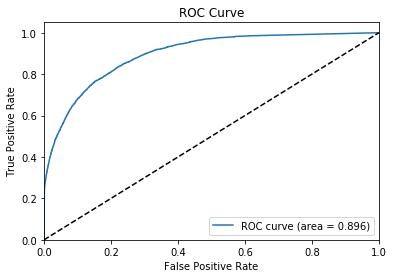

In [190]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, Bag_2.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.3f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The ROC curve for the bagging classifer is very similar to the RF ROC curve. The area under the curve is .004 higher than RF, and the curve is noticeably steeper along the y-axis, illustrating this model's higher recall without sacrifice in precision. 

### Bagging classifier 3

Since adding a higher number of estimators (500) for the boosting classifier 2, I was curious to add even more (750) to see how accuracy and F1 scores would be impacted. I also added in the out of bag (oob) score parameter so that the model will be cross validated as it is built. This will lessen the need to perform further cross-validation with this computationally expensive model. 

In [263]:
Bag_3 = BaggingClassifier(n_estimators=750, random_state=0,oob_score=True,n_jobs=-1)
Bag_3.fit(features_train, target_train)
Bag_3_predicted=Bag_3.predict(features_test)
expected = target_test
print("Bagging Accuracy", accuracy_score(expected,Bag_3_predicted))
print(classification_report(expected, Bag_3_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, Bag_3_predicted))

Bagging Accuracy 0.8534575420996059
             precision    recall  f1-score   support

         No       0.89      0.92      0.91     14939
        Yes       0.71      0.63      0.67      4598

avg / total       0.85      0.85      0.85     19537

[[13778  1161]
 [ 1702  2896]]


Adding more estimators to the bagging classifier increased accuracy by a tiny amount (.0004). The precision, recall, and thus, F1-score metrics were unchanged. Since adding 250 estimators increased the time it took to run this model, and did not result in any real increase in accuracy, the second bagging classifier is preferred.

# Boosting

### Adaboost 1

In [191]:
from sklearn.ensemble import AdaBoostClassifier
Boost_1 = AdaBoostClassifier()
print(Boost_1)
Boost_1.fit(features_train, target_train)
Boost_1_predicted=Boost_1.predict(features_test)
expected = target_test
print("Adaboost Accuracy", accuracy_score(expected,Boost_1_predicted))
print(classification_report(expected, Boost_1_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, Boost_1_predicted))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Adaboost Accuracy 0.8582177406971387
             precision    recall  f1-score   support

         No       0.89      0.94      0.91     14939
        Yes       0.74      0.61      0.67      4598

avg / total       0.85      0.86      0.85     19537

[[13978   961]
 [ 1809  2789]]


This model performed similarly to the bagging classifier, though with higher positive-class precision and lower recall. Let's change the number of estimators to see if it improves.

### Adaboost 2

In [194]:
Boost_2 = AdaBoostClassifier(n_estimators=300)
Boost_2.fit(features_train, target_train)
Boost_2_predicted=Boost_2.predict(features_test)
expected = target_test
print("Adaboost Accuracy", accuracy_score(expected,Boost_2_predicted))
print(classification_report(expected, Boost_2_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, Boost_2_predicted))

Adaboost Accuracy 0.868403541997236
             precision    recall  f1-score   support

         No       0.89      0.94      0.92     14939
        Yes       0.76      0.64      0.70      4598

avg / total       0.86      0.87      0.86     19537

[[14036   903]
 [ 1668  2930]]


Increasing the number of estimators noticeably improved the model. Accuracy is the highest seen so far, as well as F1 scores. Let's do a grid search to find the best number of estimators.

#### n_estimators Grid Search

In [196]:
param_grid = {"n_estimators": [100,200,300,400,500]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(Boost_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print("Scores", grid_search.cv_results_)
print("Best Score", grid_search.best_score_)
print("Best Param", grid_search.best_params_)

Time to run 26.517276999999922 seconds
Scores {'mean_fit_time': array([ 8.26637642, 16.83995024, 21.87350655, 33.35217134, 33.94882433]), 'std_fit_time': array([0.04572944, 0.06277779, 1.15362772, 1.49602914, 3.47588098]), 'mean_score_time': array([0.33363835, 0.69278757, 1.12630542, 1.55722706, 1.07858753]), 'std_score_time': array([0.02350045, 0.13313531, 0.15585343, 0.33775301, 0.25169943]), 'param_n_estimators': masked_array(data=[100, 200, 300, 400, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 300}, {'n_estimators': 400}, {'n_estimators': 500}], 'split0_test_score': array([0.86794964, 0.86958747, 0.87081585, 0.87081585, 0.87061112]), 'split1_test_score': array([0.86302211, 0.86680999, 0.86824324, 0.86895987, 0.8704955 ]), 'split2_test_score': array([0.86056511, 0.86353399, 0.86486486, 0.86466011, 0.86506962]), 'mean_test_score': array([0.86384

#### Learning_rate grid search

In [261]:
param_grid = {"learning_rate": [.5,1,2,3,4]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(Boost_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print("Scores", grid_search.cv_results_)
print("Best Score", grid_search.best_score_)
print("Best Param", grid_search.best_params_)

Time to run 3.5108110000001034 seconds
Scores {'mean_fit_time': array([3.68686597, 3.77120829, 3.55549463, 0.95431598, 0.79231334]), 'std_fit_time': array([0.11628686, 0.03343444, 0.28284283, 0.05920134, 0.01206951]), 'mean_score_time': array([0.19543346, 0.17502729, 0.14243595, 0.19068162, 0.1337324 ]), 'std_score_time': array([0.00531585, 0.02178867, 0.03503478, 0.00646887, 0.00314158]), 'param_learning_rate': masked_array(data=[0.5, 1, 2, 3, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.5}, {'learning_rate': 1}, {'learning_rate': 2}, {'learning_rate': 3}, {'learning_rate': 4}], 'split0_test_score': array([0.86109121, 0.86344559, 0.7581124 , 0.2418876 , 0.2418876 ]), 'split1_test_score': array([0.85636773, 0.85821048, 0.75808763, 0.24191237, 0.24191237]), 'split2_test_score': array([0.85687961, 0.85728911, 0.75808763, 0.24191237, 0.24191237]), 'mean_test_score': array([0.85811295, 0.85964852

The best n_estimators is 500, according to the grid search. The best learning rate was identified as the default of 1.0. Let's run another model with this number.

### Adaboost 3

In [197]:
Boost_3 = AdaBoostClassifier(n_estimators=500)
Boost_3.fit(features_train, target_train)
Boost_3_predicted=Boost_3.predict(features_test)
expected = target_test
print("Adaboost Accuracy", accuracy_score(expected,Boost_3_predicted))
print(classification_report(expected, Boost_3_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, Boost_3_predicted))

Adaboost Accuracy 0.8706044940369555
             precision    recall  f1-score   support

         No       0.90      0.94      0.92     14939
        Yes       0.77      0.64      0.70      4598

avg / total       0.87      0.87      0.87     19537

[[14051   888]
 [ 1640  2958]]


#### Cross-validate

In [199]:
# Will use K = 10
Boost_3_CV_scores = cross_val_score(Boost_3, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', Boost_3_CV_scores)
print('CV mean score: ', Boost_3_CV_scores.mean())  

CV Score for each K [0.87853975 0.86932787 0.87103378 0.86216308 0.87853975 0.86591607
 0.86996587 0.87406143 0.8662116  0.86138614]
CV mean score:  0.8697145346702516


The CV scores have great consistency, all within +/- .01 of the mean, which is .8697, the highest CV mean seen so far.

ROC AUC: 0.926


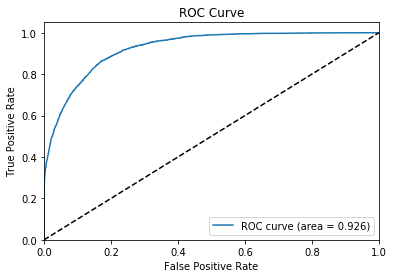

In [198]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, Boost_3.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.3f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The ROC curve illustrates a steeper and fatter curve than prevous models, with a AUC of .926.

So far, Adaboost 3, having 500 estimators, is the best performer.

# Stacking

### Stacking ensemble 1

In [200]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#Three Models RF, NB, BDT
Stack_RF = RandomForestClassifier(random_state=1)
Stack_NB = GaussianNB()
Stack_BT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=200)
Stack_1 = VotingClassifier(estimators=[('Random Forest', Stack_RF), ('Gaussian NB', Stack_NB), 
                                       ('Boosted Tree', Stack_BT)], voting='hard')
for MV, label in zip([Stack_RF, Stack_NB, Stack_BT, Stack_1], ['Random Forest', 'naive Bayes', 
                                                'AdaBoost Decision Tree', 'Ensemble']):

    Stack_scores = cross_val_score(MV, features_train, target_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (Stack_scores.mean(), Stack_scores.std(), label))

Accuracy: 0.84 (+/- 0.00) [Random Forest]
Accuracy: 0.63 (+/- 0.02) [naive Bayes]
Accuracy: 0.87 (+/- 0.00) [AdaBoost Decision Tree]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

Accuracy: 0.85 (+/- 0.00) [Ensemble]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accuracy of the ensemble was .85. This is a good accuracy, however the Naive Bayes model accuracy was only .63. Let's try replacing it with a bagging classifier. 

### Stacking ensemble 2

In [201]:
#Three Models RF, Bag, BT
Stack_RF = RandomForestClassifier(random_state=1)
Stack_Bag = BaggingClassifier(n_estimators=500, random_state=0)
Stack_BT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=200)
Stack_2 = VotingClassifier(estimators=[('Random Forest', Stack_RF), ('Bagging Classifier', Stack_Bag), 
                                       ('Boosted Tree', Stack_BT)], voting='hard')
for MV, label in zip([Stack_RF, Stack_Bag, Stack_BT, Stack_2], ['Random Forest', 'Bagging Classifier', 
                                                'AdaBoost Decision Tree', 'Ensemble']):

    Stack2_scores = cross_val_score(MV, features_train, target_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (Stack2_scores.mean(), Stack2_scores.std(), label))

Accuracy: 0.84 (+/- 0.00) [Random Forest]
Accuracy: 0.85 (+/- 0.00) [Bagging Classifier]
Accuracy: 0.87 (+/- 0.00) [AdaBoost Decision Tree]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

Accuracy: 0.86 (+/- 0.00) [Ensemble]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Replacing the NB model with a bagging classifier increased the ensemble's accuracy by .01.

In [268]:
#Three Models RF_1, Bag_2, Boost_3

Stack_3 = VotingClassifier(estimators=[('Random Forest', RF_1), ('Bagging Classifier', Bag_2), 
                                       ('Adaboost', Boost_3)], voting='hard')
for MV, label in zip([RF_1, Bag_2, Boost_3, Stack_3], ['Random Forest', 'Bagging Classifier', 
                                                'AdaBoost', 'Ensemble']):

    Stack3_scores = cross_val_score(MV, features_train, target_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (Stack3_scores.mean(), Stack3_scores.std(), label))

Accuracy: 0.85 (+/- 0.00) [Random Forest]
Accuracy: 0.85 (+/- 0.00) [Bagging Classifier]
Accuracy: 0.87 (+/- 0.00) [AdaBoost]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

Accuracy: 0.86 (+/- 0.00) [Ensemble]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Creating a stacking model with the three best performing models (RF_1, Bag_2, and Boost_3) did not improve the ensemble enough to increase its accuracy score, although the score for RF_1 was higher than the standard RF model included in the other stacking models. 

# Stochastic Gradient Descent

### SGD 1

In [242]:
## Untuned

from sklearn.linear_model import SGDClassifier

SGD_1 = SGDClassifier()
print(SGD_1)
SGD_1.fit(features_train, target_train)
SGD_1_predicted=SGD_1.predict(features_test)
expected = target_test
print("SGD Accuracy", accuracy_score(expected,SGD_1_predicted))
print(classification_report(expected, SGD_1_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, SGD_1_predicted))


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Adaboost Accuracy 0.8345191175717869
             precision    recall  f1-score   support

         No       0.90      0.88      0.89     14939
        Yes       0.64      0.69      0.66      4598

avg / total       0.84      0.83      0.84     19537

[[13133  1806]
 [ 1427  3171]]


### SGD 2

In [247]:
SGD_2 = SGDClassifier(class_weight = 'balanced')
print(SGD_2)
SGD_2.fit(features_train, target_train)
SGD_2_predicted=SGD_2.predict(features_test)
expected = target_test
print("SGD Accuracy", accuracy_score(expected,SGD_2_predicted))
print(classification_report(expected, SGD_2_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, SGD_2_predicted))

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
SGD Accuracy 0.8110764191022163
             precision    recall  f1-score   support

         No       0.93      0.81      0.87     14939
        Yes       0.57      0.80      0.67      4598

avg / total       0.85      0.81      0.82     19537

[[12157  2782]
 [  909  3689]]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### SGD 3

In [248]:
SGD_3 = SGDClassifier(loss = 'log', class_weight = 'balanced')
print(SGD_3)
SGD_3.fit(features_train, target_train)
SGD_3_predicted=SGD_3.predict(features_test)
expected = target_test
print("SGD Accuracy", accuracy_score(expected,SGD_3_predicted))
print(classification_report(expected, SGD_3_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, SGD_3_predicted))

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
SGD Accuracy 0.7946460562010544
             precision    recall  f1-score   support

         No       0.95      0.77      0.85     14939
        Yes       0.54      0.86      0.66      4598

avg / total       0.85      0.79      0.81     19537

[[11553  3386]
 [  626  3972]]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


# Gradient Boost Classification

### Gradient Boost 1

Untuned

In [205]:
from sklearn.ensemble import GradientBoostingClassifier
GBC_1 = GradientBoostingClassifier()
GBC_1.fit(features_train, target_train)
GBC_1_predicted = GBC_1.predict(features_test)
expected = target_test
print("Gradient Boost Accuracy", accuracy_score(expected,GBC_1_predicted))
print(classification_report(expected, GBC_1_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, GBC_1_predicted))



Gradient Boost Accuracy 0.8667144392690792
             precision    recall  f1-score   support

         No       0.89      0.95      0.92     14939
        Yes       0.78      0.60      0.68      4598

avg / total       0.86      0.87      0.86     19537

[[14168   771]
 [ 1833  2765]]


The gradient boost classifier was significantly outperformed by the adaboost model. Gradient boost only had a positive class recall of .60 with .78 precision. The negative class metrics were quite high, resulting in a relatively high accuracy (.866). The overall accuracy rate does not make up for the less than desireable metrics of the positive class. 

### Gradient Boost 2

Need to print model to decide tuning parameters.

In [204]:
print(GradientBoostingClassifier())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [206]:
from sklearn.ensemble import GradientBoostingClassifier
GBC_2 = GradientBoostingClassifier(learning_rate=.5,max_depth=5)
GBC_2.fit(features_train, target_train)
GBC_2_predicted = GBC_2.predict(features_test)
expected = target_test
print("Gradient Boost Accuracy", accuracy_score(expected,GBC_2_predicted))
print(classification_report(expected, GBC_2_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, GBC_2_predicted))



Gradient Boost Accuracy 0.8670215488560168
             precision    recall  f1-score   support

         No       0.90      0.93      0.91     14939
        Yes       0.75      0.65      0.70      4598

avg / total       0.86      0.87      0.86     19537

[[13928  1011]
 [ 1587  3011]]


Increasing the learning rate and max_depth parameters seemed to improve the model. Positive class recall and precision increased, resulting in a F1 score of .70. Need to grid search to find best value.

#### Grid Search learning_rate

In [208]:
param_grid = {"learning_rate": [.1,.5,1,1.5,2,2.5]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(GBC_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print("Scores", grid_search.cv_results_)
print("Best Score", grid_search.best_score_)
print("Best Param", grid_search.best_params_)

Time to run 14.974361999999928 seconds
Scores {'mean_fit_time': array([19.25587447, 18.93903565, 18.75839845, 20.31092032, 23.06653341,
       17.09752234]), 'std_fit_time': array([0.20204769, 0.662837  , 0.42305524, 0.46397959, 0.73585114,
       3.03311984]), 'mean_score_time': array([0.05924757, 0.06090196, 0.06034915, 0.06690033, 0.06305997,
       0.0705471 ]), 'std_score_time': array([0.01137305, 0.0062867 , 0.00775264, 0.01158964, 0.00366742,
       0.01667832]), 'param_learning_rate': masked_array(data=[0.1, 0.5, 1, 1.5, 2, 2.5],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.1}, {'learning_rate': 0.5}, {'learning_rate': 1}, {'learning_rate': 1.5}, {'learning_rate': 2}, {'learning_rate': 2.5}], 'split0_test_score': array([0.868052  , 0.8729655 , 0.86917801, 0.84747671, 0.6429522 ,
       0.6174634 ]), 'split1_test_score': array([0.86527437, 0.86875512, 0.86302211, 0.85083948, 0.73454

The best learning rate value is .05 according to the grid search. Now we need to see what the best max_depth value is.

#### Grid Search max_depth

In [209]:
param_grid = {"max_depth": [2,3,4,5,6,7]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(GBC_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print("Scores", grid_search.cv_results_)
print("Best Score", grid_search.best_score_)
print("Best Param", grid_search.best_params_)

Time to run 26.238706000000093 seconds
Scores {'mean_fit_time': array([13.23684128, 23.26123492, 31.63080152, 38.72426963, 48.30999207,
       46.94985104]), 'std_fit_time': array([0.22008175, 0.39085287, 1.16192095, 1.56999897, 0.68689688,
       7.52222928]), 'mean_score_time': array([0.09115767, 0.06827386, 0.0732828 , 0.07673573, 0.07520684,
       0.04902363]), 'std_score_time': array([0.02046476, 0.02213254, 0.01137954, 0.00764054, 0.00295623,
       0.0103844 ]), 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}], 'split0_test_score': array([0.86242195, 0.86815437, 0.87306787, 0.87337496, 0.87317023,
       0.87276077]), 'split1_test_score': array([0.86066749, 0.86537674, 0.86803849, 0.87151925, 0.86967649,
       0.86936937]), 'split2_test_score

Best max_depth is 5. These optimal parameters are exactly what I put in Gradient Boost 2, by guessing. There is no need to make adjustments to these. I am curious how changing the number of estimators will affect the output, so we're going to run a third grid search.

#### Grid Search number of estimators

In [210]:
param_grid = {"n_estimators": [100,200,300,400,500]}
start_time = time.clock()

# run grid search 
grid_search = GridSearchCV(GBC_1, param_grid=param_grid,n_jobs=-1)

grid_search.fit(features_train, target_train)

print("Time to run", time.clock() - start_time, "seconds")
print("Scores", grid_search.cv_results_)
print("Best Score", grid_search.best_score_)
print("Best Param", grid_search.best_params_)

Time to run 59.15599799999973 seconds
Scores {'mean_fit_time': array([18.69635296, 46.35900966, 67.7995917 , 86.09140674, 77.0262297 ]), 'std_fit_time': array([ 0.12680681,  3.94747637,  2.36147135,  2.01700978, 10.84394459]), 'mean_score_time': array([0.05779465, 0.18024397, 0.19499334, 0.21599905, 0.131061  ]), 'std_score_time': array([0.00734664, 0.03977338, 0.02617898, 0.04033223, 0.04048681]), 'param_n_estimators': masked_array(data=[100, 200, 300, 400, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 300}, {'n_estimators': 400}, {'n_estimators': 500}], 'split0_test_score': array([0.86815437, 0.87235132, 0.87357969, 0.87286314, 0.87286314]), 'split1_test_score': array([0.86537674, 0.86711712, 0.86855037, 0.870086  , 0.86967649]), 'split2_test_score': array([0.86343161, 0.86977887, 0.87070025, 0.8704955 , 0.8713145 ]), 'mean_test_score': array([0.8

The best number of estimators according to the grid search is 500. Now we will make a third gradient boost model with these tunings added.

### Gradient Boost 3

In [211]:
from sklearn.ensemble import GradientBoostingClassifier
GBC_3 = GradientBoostingClassifier(learning_rate=.5,max_depth=5,n_estimators=500)
GBC_3.fit(features_train, target_train)
GBC_3_predicted = GBC_3.predict(features_test)
expected = target_test
print("Gradient Boost Accuracy", accuracy_score(expected,GBC_3_predicted))
print(classification_report(expected, GBC_3_predicted,target_names=['No', 'Yes']))
print(confusion_matrix(expected, GBC_3_predicted))

Gradient Boost Accuracy 0.8576035215232636
             precision    recall  f1-score   support

         No       0.89      0.92      0.91     14939
        Yes       0.72      0.65      0.68      4598

avg / total       0.85      0.86      0.85     19537

[[13774  1165]
 [ 1617  2981]]


Surprisingly, the metrics of this model were not an improvement. Gradient Boost 2 is the best of the three. Now we'll cross-validate it to check its consistency. 

### Cross-validation for Gradient Boost 2

In [212]:
# Will use K = 10
GBC_2_CV_scores = cross_val_score(GBC_2, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', GBC_2_CV_scores)
print('CV mean score: ', GBC_2_CV_scores.mean())  

CV Score for each K [0.86932787 0.860116   0.8723985  0.8567042  0.87478676 0.86386899
 0.86450512 0.86860068 0.86348123 0.86104473]
CV mean score:  0.8654834075906189


The CV scores are consistent, all falling within +/- .02 of the mean, which is .865. Despite this high accuracy, the Gradient Boost will be included with the Adaboost model as the best performers so far. 

# Neural Nets

### ANN 1

In [240]:
from sklearn.neural_network import MLPClassifier

# Default parameters 
NN_1 =MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
#fit the model
NN_1.fit(features_train, target_train)

# test random forest model
NN_1_predicted = NN_1.predict(features_test)
print("Accuracy", accuracy_score(target_test, NN_1_predicted))
target_names = ["<=50K", ">50K"]
print(classification_report(target_test, NN_1_predicted, target_names=target_names))
print(confusion_matrix(target_test, NN_1_predicted))

Accuracy 0.8557608640016379
             precision    recall  f1-score   support

      <=50K       0.87      0.95      0.91     14939
       >50K       0.78      0.54      0.64      4598

avg / total       0.85      0.86      0.85     19537

[[14235   704]
 [ 2114  2484]]


The Neural Net performed on par with most of the models constructed so far, but did not match that of Adaboost or Gradient Boost. Let's tinker with the parameters.

### ANN 2

In [241]:
NN_2 =MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
#fit the model
NN_2.fit(features_train, target_train)

# test random forest model
NN_2_predicted = NN_2.predict(features_test)
print("Accuracy", accuracy_score(target_test, NN_2_predicted))
target_names = ["<=50K", ">50K"]
print(classification_report(target_test, NN_2_predicted, target_names=target_names))
print(confusion_matrix(target_test, NN_2_predicted))

Accuracy 0.8551466448277627
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91     14939
       >50K       0.79      0.53      0.63      4598

avg / total       0.85      0.86      0.84     19537

[[14288   651]
 [ 2179  2419]]


I cahnged the number of hidden layers from one layer with 15 nodes to two layers with 100 and 50 nodes. The positive class recall incresed by .02 while its precision decreased by .01, and negative class recall decreased by .01 and precision remained unchanged. Even though the average F1 score was unchanged and overall accuracy decreased very slightly, this second model is more desireable due to a significantly higher positive class recall. 

### ANN 3

In [239]:
NN_3 =MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(50,50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
#fit the model
NN_3.fit(features_train, target_train)

# test random forest model
NN_3_predicted = NN_3.predict(features_test)
print("Accuracy", accuracy_score(target_test, NN_3_predicted))
target_names = ["<=50K", ">50K"]
print(classification_report(target_test, NN_3_predicted, target_names=target_names))
print(confusion_matrix(target_test, NN_3_predicted))

Accuracy 0.8548395352408251
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91     14939
       >50K       0.80      0.51      0.63      4598

avg / total       0.85      0.85      0.84     19537

[[14337   602]
 [ 2234  2364]]


Changing the number of nodes in the two hidden layers to 50 and 50 increased positive class recall by .05 and decreased its precision by .03. Negative class recall decreased by .02 with precision increasing by .03. The overall accuracy decreased only by .002 and the average F1 score remained unchanged. This model is preferable due to the higher positive class recall.

#### Cross-validate ANN 3

In [228]:
# Will use K = 10
NN_3_CV_scores = cross_val_score(NN_3, features_train, target_train, cv=10,scoring='accuracy')
print('CV Score for each K', NN_3_CV_scores)
print('CV mean score: ', NN_3_CV_scores.mean())  

CV Score for each K [0.8618219  0.85090413 0.85568066 0.8461276  0.8618219  0.84680996
 0.85767918 0.8559727  0.85426621 0.85046091]
CV mean score:  0.8541545151792922


This model has good consistency and is one of the better-performing models constructed so far. However, the gradient boost and adaboost models ill be preferred over it due to their higher metrics. The positive class recall in this model was particularly unfavorable. 

# Stacking revisited

After constructing a few more ensembles, let's try another stacking model that includes the Gradient Boost model.

In [274]:
#Three Models RF_1, Bag_2, Boost_3, GBC_2

Stack_4 = VotingClassifier(estimators=[('Random Forest', RF_1), ('Bagging Classifier', Bag_2), 
                                       ('Adaboost', Boost_3),('Gradient Boost', GBC_2)], voting='hard')
for MV, label in zip([RF_1, Bag_2, Boost_3, GBC_2, Stack_4], ['Random Forest', 'Bagging Classifier', 
                                                'AdaBoost', 'Gradient Boost', 'Ensemble']):

    Stack4_scores = cross_val_score(MV, features_train, target_train, cv=5, scoring='f1_weighted')
    print("f1_score: %0.2f (+/- %0.2f) [%s]" % (Stack4_scores.mean(), Stack4_scores.std(), label))

f1_score: 0.84 (+/- 0.00) [Random Forest]
f1_score: 0.84 (+/- 0.00) [Bagging Classifier]
f1_score: 0.87 (+/- 0.00) [AdaBoost]
f1_score: 0.86 (+/- 0.00) [Gradient Boost]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWar

f1_score: 0.86 (+/- 0.00) [Ensemble]


/Users/kristopherprofit/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


This stacking model has one of the highest accuracies in the analysis, at .87. Despite this high score, the Adaboost 3 model is preferred due to the high comutational expense of the stacking model.  

# Conclusion

Judging by overall model accuracy and average F1 score, the best performer on this dataset was the Adaboost 3 model. i tuned this model to use 500 estimators to make its final predicton, as opposed to the default 100. Its overall accuracy was .87 with a mean cross-validation score of .87. The average F1 score was also .87. While this model did not have the highest recall for the positive class, it did have a relatively high precision. I noticed that this model had the most consistency when cross-validating, with all accuracy scores being within +/- .01 of the mean. This model not only had the highest F1 scores, but is also the most reliable to produce consistent results.

#### Metrics

In [229]:
# Adaboost 3
print("Adaboost Accuracy", accuracy_score(expected,Boost_3_predicted))
print(classification_report(expected, Boost_3_predicted,target_names=['No', 'Yes']))

Adaboost Accuracy 0.8706044940369555
             precision    recall  f1-score   support

         No       0.90      0.94      0.92     14939
        Yes       0.77      0.64      0.70      4598

avg / total       0.87      0.87      0.87     19537



#### Confusion Matrix

[[14051   888]
 [ 1640  2958]]


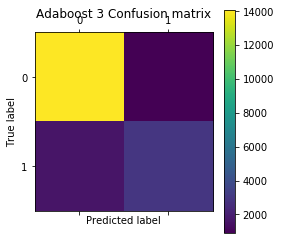

In [234]:
# AdBoostoost 3
Boost_3_cm = confusion_matrix(target_test, Boost_3_predicted)
plt.matshow(Boost_3_cm)
plt.title('Adaboost 3 Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(Boost_3_cm)

#### ROC curve

ROC AUC: 0.926


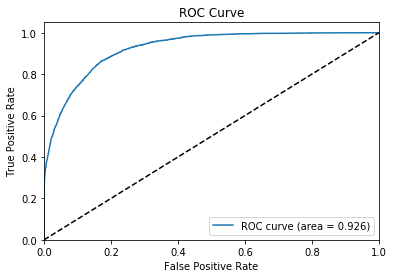

In [236]:
# Adaboost 3

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, Boost_3.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.3f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Importance of each predictor

In [249]:
print("Features sorted by their score:")
print("Higher the more important")
print(sorted(zip(map(lambda x: round(x, 4), Boost_3.feature_importances_),Adult.columns[1:14]), 
             reverse=True))

Features sorted by their score:
Higher the more important
[(0.454, 'capital-gain'), (0.284, 'capital-loss'), (0.078, 'age'), (0.024, 'hours-per-week'), (0.012, 'education-num'), (0.002, 'workclass_ Self-emp-not-inc'), (0.002, 'workclass_ Self-emp-inc'), (0.002, 'workclass_ Private'), (0.002, 'workclass_ Federal-gov'), (0.0, 'workclass_ State-gov'), (0.0, 'workclass_ Never-worked'), (0.0, 'workclass_ Local-gov'), (0.0, 'workclass_ ?')]


The importance of predictors in the Adaboost 3 model was similar, though in a different order than the random forest model. Adaboost listed capital gain and capital loss as explaining 45.4% and 28.4% of variance in whether or not a person makes over 50K a year, respectively. This makes intuitive sense, as the ability to realize capital gain or loss is based on one's ability to save and invest money. This suggests that those instances that have higher values of capital gain or loss are more likely to earn more than 50K per year and engage in investment activity. Age explains 7.8 percent of the variance in the data and is an intuitive indicator of one's income- the more years of experience someone has, the more likely they are to earn more than 50K. Hours worked per week explained 2.4 percent of the variance. This is an obvious and direct contributor to one's income. Education level explained 1.2 percent of the variance- another intuitive indicator of income, as higher education usually leads to more lucrative vocations. 